## IST 718 Lab 1 Conard, Jacob

## Import

In [1]:
import pandas as pd
import numpy as np
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

## Read in the data and clean

In [2]:
# Import the coaches data, graduation rate data, statdium data, and 2022 score data to merge it all together
coaches = pd.read_csv('Coaches9.csv').fillna(0)
grad_rates = pd.read_csv('graduation_rate.csv').fillna(0)
stadiums = pd.read_csv('stadiums-geocoded.csv').fillna(0)
season_2022 = pd.read_csv('teams_wins.csv').fillna(0)

In [3]:
# Shape of all of the pandas dataframes
print('The shape of the Coaches dataframe is ' + str(coaches.shape))
print('The shape of the Graduation Rate dataframe is ' + str(grad_rates.shape))
print('The shape of the Stadiums dataframe is ' + str(stadiums.shape))
print('The shape of the Wins & Losses dataframe is ' + str(season_2022.shape))

The shape of the Coaches dataframe is (129, 9)
The shape of the Graduation Rate dataframe is (118, 2)
The shape of the Stadiums dataframe is (253, 11)
The shape of the Wins & Losses dataframe is (118, 4)


In [4]:
# Isolating the quantitative attributes
stadiums_quant = ['capacity', 'built', 'expanded']
grad_quant = [' gsr ']
season_quant = ['win', 'loss', 'pct']
coaches_quant = [
    'schoolpay',
    'totalpay',
    'bonus',
    'bonuspaid',
    'assistantpay',
    'buyout'
]

## Clean the data and make some of the data lowercase

In [5]:
# convert team names to lowercase
coaches = coaches.apply(lambda x: x.astype(str).str.lower())
stadiums = stadiums.apply(lambda x: x.astype(str).str.lower())
grad_rates = grad_rates.apply(lambda x: x.astype(str).str.lower())
season_2022 = season_2022.apply(lambda x: x.astype(str).str.lower())

# column names to lowercase
coaches.columns = coaches.columns.str.lower()
stadiums.columns = stadiums.columns.str.lower()
grad_rates.columns = grad_rates.columns.str.lower()
season_2022.columns = season_2022.columns.str.lower()

# Convert non-numeric to empty space
coaches[coaches_quant] = coaches[coaches_quant].replace('[\$,--]', '', regex=True)

# convert column name: allows dataframe merge
stadiums = stadiums.rename(columns={'team': 'school'})

# coerce monetary to numeric
stadiums[stadiums_quant] = stadiums[stadiums_quant].apply(
    pd.to_numeric,
    errors='coerce',
    axis=1
).fillna(0)

# coerce monetary to numeric
coaches[coaches_quant] = coaches[coaches_quant].apply(
    pd.to_numeric,
    errors='coerce',
    axis=1
).fillna(0)

# coerce graduation rate to numeric
grad_rates[grad_quant] = grad_rates[grad_quant].apply(
    pd.to_numeric,
    errors='coerce',
    axis=1
).fillna(0)

# coerce season rate to numeric
season_2022[season_quant] = season_2022[season_quant].apply(
    pd.to_numeric,
    errors='coerce',
    axis=1
).fillna(0)

C:\Users\jncon\anaconda3\lib\site-packages\pandas\core\dtypes\inference.py:213: FutureWarning: Possible set difference at position 4
  re.compile(obj)


## Normalize some of the school names

In [6]:
# stadium only columns
stadiums = stadiums[['stadium', 'school'] + stadiums_quant]

# replace acronym with school name
stadiums['school'] = stadiums['school'].replace(['ucf'], 'central florida')
stadiums['school'] = stadiums['school'].replace(['usf'], 'south florida')
stadiums['school'] = stadiums['school'].replace(['utsa'], 'texas-san antonio')
stadiums['school'] = stadiums['school'].replace(['byu'], 'brigham young')
stadiums['school'] = stadiums['school'].replace(['utep'], 'texas-el paso')
stadiums['school'] = stadiums['school'].replace(['tcu'], 'texas christian')
stadiums['school'] = stadiums['school'].replace(['unlv'], 'nevada-las vegas')
stadiums['school'] = stadiums['school'].replace(['smu'], 'southern methodist')
stadiums['school'] = stadiums['school'].replace(['niu'], 'northern illinois')
stadiums['school'] = stadiums['school'].replace(['miami (oh)'], 'miami (ohio)')
stadiums['school'] = stadiums['school'].replace(['fiu'], 'florida international')
stadiums['school'] = stadiums['school'].replace(['umass'], 'massachusetts')
stadiums['school'] = stadiums['school'].replace(['yale bulldogs'], 'connecticut')

stadiums = stadiums[stadiums['expanded'] <= 2006]

## Create a barchart with the top 25 schools and the highest stadium capacity

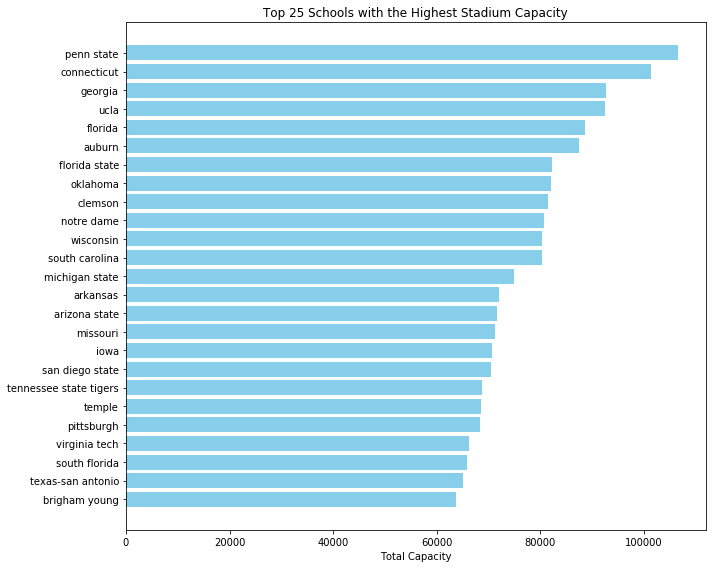

In [7]:
# Group the data by school and sum the capacities
school_capacity = stadiums.groupby('school')['capacity'].sum().reset_index()

# Sort the data by capacity in descending order
school_capacity = school_capacity.sort_values(by='capacity', ascending=False)

# Select the top 25 schools
top_25_schools = school_capacity.head(25)

# Create a horizontal bar chart for the top 25 schools
plt.figure(figsize=(10, 8))
plt.barh(top_25_schools['school'], top_25_schools['capacity'], color='skyblue')
plt.title('Top 25 Schools with the Highest Stadium Capacity')
plt.xlabel('Total Capacity')

plt.tight_layout()
plt.gca().invert_yaxis()  # Invert the y-axis to have the highest capacity at the top
plt.show()

In [8]:
coaches.head()

,school,conference,coach,schoolpay,totalpay,bonus,bonuspaid,assistantpay,buyout
0,air force,mt. west,troy calhoun,885000.0,885000.0,247000.0,0.0,0.0,0.0
1,akron,mac,terry bowden,411000.0,412500.0,225000.0,50000.0,0.0,688500.0
2,alabama,sec,nick saban,8307000.0,8307000.0,1100000.0,500000.0,0.0,33600000.0
3,alabama at birmingham,c-usa,bill clark,900000.0,900000.0,950000.0,165471.0,0.0,3847500.0
4,appalachian state,sun belt,scott satterfield,712500.0,712500.0,295000.0,145000.0,0.0,2160417.0


## Create a barchart with the top 25 schools and their coaches salaries

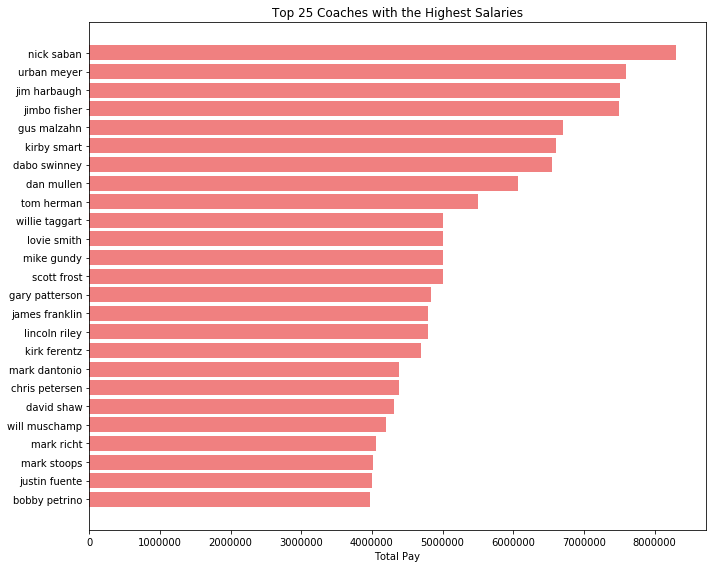

In [9]:
# Sort the data by totalpay (coaches' salaries) in descending order
coaching_df = coaches.sort_values(by='totalpay', ascending=False)

# Select the top 25 coaches
top_25_coaches = coaching_df.head(25)

# Create a horizontal bar chart for the top 25 coaches' salaries
plt.figure(figsize=(10, 8))
plt.barh(top_25_coaches['coach'], top_25_coaches['totalpay'], color='lightcoral')
plt.title('Top 25 Coaches with the Highest Salaries')
plt.xlabel('Total Pay')

# Show the plot
plt.tight_layout()
plt.gca().invert_yaxis()  # Invert the y-axis to have
plt.show()

In [10]:
season_2022.head()

,school,win,loss,pct
0,air force,10.0,3.0,0.769231
1,akron,5.0,7.0,0.416667
2,alabama,14.0,1.0,0.933333
3,appalachian state,10.0,3.0,0.769231
4,arizona,3.0,9.0,0.250000


## Create a barchart with the top 25 schools and their 2022 season winning percentages

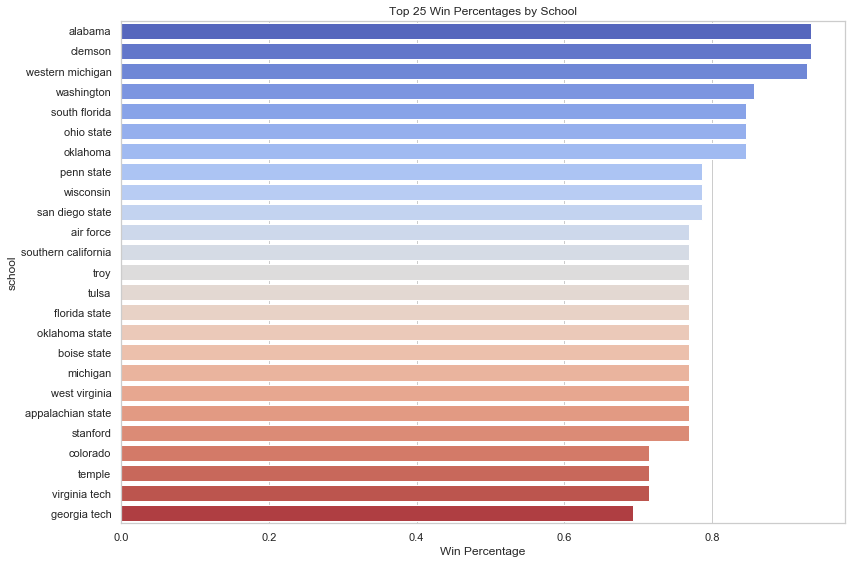

In [11]:
# Sort the data by win percentage in descending order to get the top win percentages
top_25_win_percentages = season_2022.sort_values(by='pct', ascending=False).head(25)

# Set a Seaborn style
sns.set(style="whitegrid")

# Create a visually appealing horizontal bar chart for the top 25 win percentages by school
plt.figure(figsize=(12, 8))
sns.barplot(x='pct', y='school', data=top_25_win_percentages, palette='coolwarm')

plt.xlabel('Win Percentage')
plt.title('Top 25 Win Percentages by School')

# Show the plot
plt.tight_layout()
plt.show()

## Create a barchart with the top 25 schools and their 2022 Graduation Rate Percentages

In [12]:
grad_rates.head()

,school,gsr
0,air force,83
1,akron,45
2,alabama,79
3,appalachian state,57
4,arizona,74


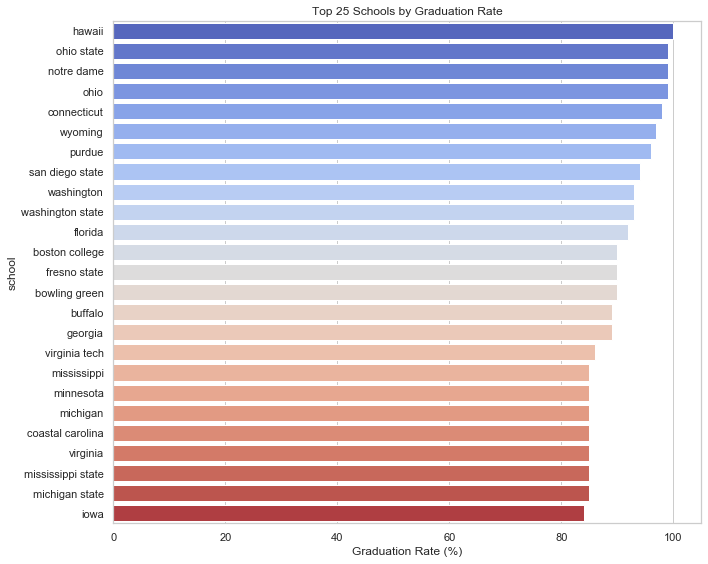

In [13]:
# Sort the data by graduation rate in descending order to get the top rates
top_25_schools = grad_rates.sort_values(by=' gsr ', ascending=False).head(25)

# Set a Seaborn style
sns.set(style="whitegrid")

# Create a visually appealing horizontal bar chart for the top 25 schools sorted by graduation rate
plt.figure(figsize=(10, 8))
sns.barplot(x=' gsr ', y='school', data=top_25_schools, palette='coolwarm')

plt.xlabel('Graduation Rate (%)')
plt.title('Top 25 Schools by Graduation Rate')

# Show the plot
plt.tight_layout()
plt.show()


In [14]:
# merge coaches + stadium
merged_df = pd.merge(coaches, stadiums, on='school', how='inner')

# merge graduation rates
merged_df = pd.merge(merged_df, grad_rates, on='school', how='inner')

# merge 2022 season
merged_df = pd.merge(merged_df, season_2022, on='school', how='inner')

In [15]:
merged_df.head()

,school,conference,coach,schoolpay,totalpay,bonus,bonuspaid,assistantpay,buyout,stadium,capacity,built,expanded,gsr,win,loss,pct
0,air force,mt. west,troy calhoun,885000.0,885000.0,247000.0,0.0,0.0,0.0,falcon stadium,46692.0,1962.0,0.0,83,10.0,3.0,0.769231
1,akron,mac,terry bowden,411000.0,412500.0,225000.0,50000.0,0.0,688500.0,summa field at infocision stadium,30000.0,2009.0,0.0,45,5.0,7.0,0.416667
2,arizona,pac-12,kevin sumlin,1600000.0,2000000.0,2025000.0,0.0,0.0,10000000.0,arizona stadium,51811.0,1928.0,1988.0,74,3.0,9.0,0.250000
3,arizona state,pac-12,herm edwards,2000000.0,2000000.0,3010000.0,0.0,0.0,8166667.0,sun devil stadium frank kush field,71706.0,1958.0,1998.0,74,5.0,7.0,0.416667
4,arkansas,sec,chad morris,3500000.0,3500000.0,1000000.0,0.0,0.0,12500000.0,donald w. reynolds razorback stadium,72000.0,1938.0,2006.0,76,7.0,6.0,0.538462


In [16]:
merged_df.shape

(78, 17)

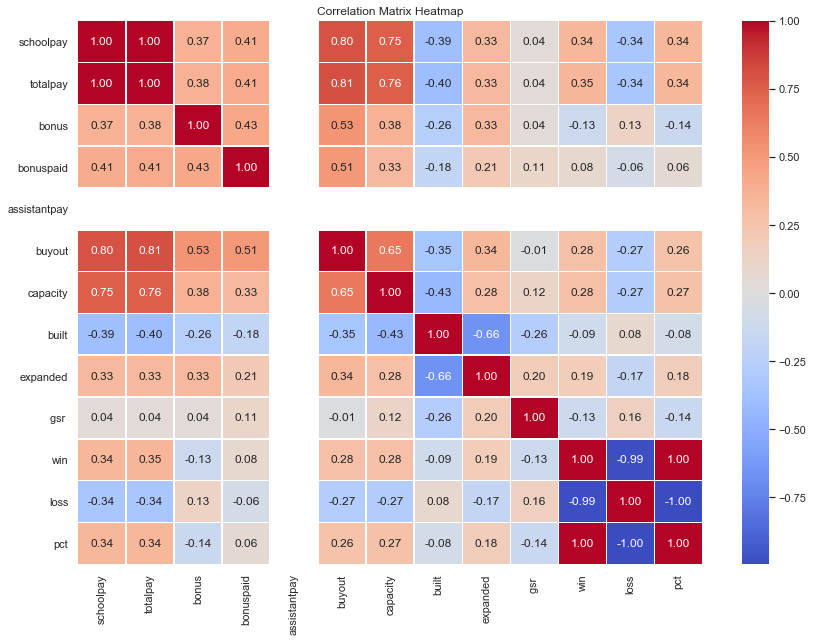

In [17]:
# Set the figure size to make sure the entire chart is visible in the notebook
plt.figure(figsize=(14, 10))

# Create a correlation matrix
corr_matrix = merged_df.corr()

# Create a heatmap using Seaborn
sns.heatmap(corr_matrix, cmap='coolwarm', annot=True, linewidths=0.5, fmt=".2f")

# Display the heatmap
plt.title("Correlation Matrix Heatmap")
plt.show()

## What is the recommended salary for the Syracuse football coach?
## What would his salary be if we were still in the Big Ten? What if we went to the SEC?

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

# Select relevant features and target variable
X = merged_df[['schoolpay', 'bonus', 'bonuspaid', 'assistantpay', 'buyout', 'capacity', ' gsr ', 'win', 'loss', 'pct']]
y = merged_df['totalpay']  # Target variable: coach's total pay

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and fit a linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [29]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {rmse}')
print(f'Mean Absolute Error: {mae}')
print(f'R-squared: {r2}')

Mean Squared Error: 1265310163.0512106
Root Mean Squared Error: 35571.19850456561
Mean Absolute Error: 25574.469234681823
R-squared: 0.9996025857225728


In [19]:

# Real-world data for Syracuse football coach and scenarios
syracuse_features = {'schoolpay': 2401206.0, 'bonus': 0.0, 'bonuspaid': 0.0, 'assistantpay': 0.0, 'buyout': 0.0, 'capacity': 49250.0, ' gsr ': 80, 'win': 4.0, 'loss': 8.0, 'pct': 0.333333}   
big_ten_features = {'schoolpay': 4087170.0, 'bonus': 959285.70, 'bonuspaid': 2135714.00, 'assistantpay': 0.0, 'buyout': 0.0, 'capacity': 69791.0, ' gsr ': 82, 'win': 7.4, 'loss': 5.5, 'pct': 0.5596} 
sec_features = {'schoolpay': 4359569.0, 'bonus': 1283333.00, 'bonuspaid': 2777778.00, 'assistantpay': 0.0, 'buyout': 1341653.00, 'capacity': 72798.44, ' gsr ': 75, 'win': 6.4, 'loss': 6.4, 'pct': 0.4985} 

# Predict salaries
syracuse_salary = model.predict([list(syracuse_features.values())])[0]
big_ten_salary = model.predict([list(big_ten_features.values())])[0]
sec_salary = model.predict([list(sec_features.values())])[0]

print(f"Recommended Salary for Syracuse Football Coach: ${syracuse_salary:,.2f}")
print(f"Salary in the Big Ten: ${big_ten_salary:,.2f}")
print(f"Salary in the SEC: ${sec_salary:,.2f}")


Recommended Salary for Syracuse Football Coach: $2,392,161.79
Salary in the Big Ten: $3,979,651.78
Salary in the SEC: $4,198,908.79


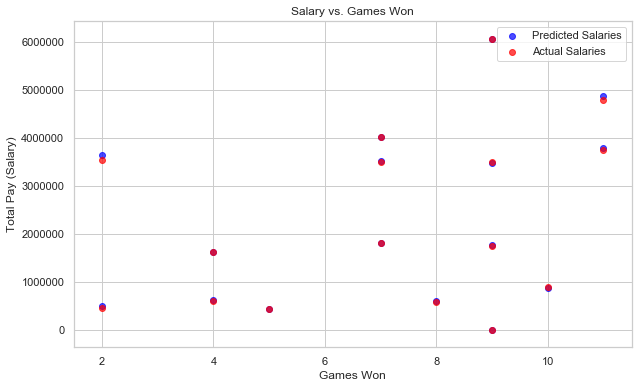

In [20]:
# Predict salaries using the trained linear regression model
y_pred = model.predict(X_test)

# Create a scatter plot of 'win' vs. predicted salaries
plt.figure(figsize=(10, 6))
plt.scatter(X_test['win'], y_pred, c='blue', label='Predicted Salaries', alpha=0.7)
plt.scatter(X_test['win'], y_test, c='red', label='Actual Salaries', alpha=0.7)

# Add labels and title
plt.xlabel('Games Won')
plt.ylabel('Total Pay (Salary)')
plt.title('Salary vs. Games Won')

# Add a legend
plt.legend()

# Show the plot
plt.show()

## What schools did we drop from our data and why?

#### The following schools had no data for totalpay:

#### Baylor	Big 12
#### Brigham Young	Ind.
#### Rice	C-USA	
#### Southern Methodist	AAC


##  As the graduation rate increases, the projected salary is expected to decrease.

In [21]:
# Get the coefficient for 'gsr' (graduation rate) from the linear regression model
gsr_coefficient = model.coef_[X.columns.get_loc(' gsr ')]

# Print the coefficient
print(f"The effect of graduation rate on projected salary is: {gsr_coefficient:.2f}")

The effect of graduation rate on projected salary is: -410.22


## How good is our model?

In [22]:
from sklearn.metrics import mean_squared_error, r2_score

# Make predictions on the test data
y_pred = model.predict(X_test)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error (MSE): {mse:.2f}")

# Calculate R-squared (R2) score
r2 = r2_score(y_test, y_pred)
print(f"R-squared (R2) Score: {r2:.2f}")

Mean Squared Error (MSE): 1265310163.05
R-squared (R2) Score: 1.00


## What is the single biggest impact on salary size?

In [23]:
# Get the absolute coefficients for all features
absolute_coefficients = abs(model.coef_)

# Find the index of the feature with the largest absolute coefficient
largest_coefficient_index = absolute_coefficients.argmax()

# Get the feature name with the largest absolute coefficient
feature_with_largest_impact = X.columns[largest_coefficient_index]

# Get the largest absolute coefficient
largest_coefficient = absolute_coefficients[largest_coefficient_index]

# Print the results
print(f"The feature with the largest impact on salary size is '{feature_with_largest_impact}' with a coefficient of {largest_coefficient:.2f}")


The feature with the largest impact on salary size is 'pct' with a coefficient of 2335135.23


## Develop a geographic visualization that in your view best depicts the conferences’ median salary

In [24]:
coaches = pd.read_csv('Coaches9.csv').fillna(0)
stadiums = pd.read_csv('stadiums-geocoded.csv').fillna(0)

In [25]:
coaches.head()

,School,Conference,Coach,SchoolPay,TotalPay,Bonus,BonusPaid,AssistantPay,Buyout
0,Air Force,Mt. West,Troy Calhoun,885000,885000,247000,--,$0,--
1,Akron,MAC,Terry Bowden,"$411,000","$412,500","$225,000","$50,000",$0,"$688,500"
2,Alabama,SEC,Nick Saban,"$8,307,000","$8,307,000","$1,100,000","$500,000",$0,"$33,600,000"
3,Alabama at Birmingham,C-USA,Bill Clark,"$900,000","$900,000","$950,000","$165,471",$0,"$3,847,500"
4,Appalachian State,Sun Belt,Scott Satterfield,"$712,500","$712,500","$295,000","$145,000",$0,"$2,160,417"


In [26]:
coaches.columns = coaches.columns.str.lower()

In [27]:
stadiums.head()

,stadium,city,state,team,conference,capacity,built,expanded,div,latitude,longitude
0,Michigan Stadium,Ann Arbor,MI,Michigan,Big Ten,107601,1927,2015,fbs,42.265869,-83.748726
1,Beaver Stadium,University Park,PA,Penn State,Big Ten,106572,1960,2001,fbs,40.812153,-77.856202
2,Ohio Stadium,Columbus,OH,Ohio State,Big Ten,104944,1922,2014,fbs,40.001686,-83.019728
3,Kyle Field,College Station,TX,Texas A&M,SEC,102733,1927,2015,fbs,30.610098,-96.340729
4,Neyland Stadium,Knoxville,TN,Tennessee,SEC,102455,1921,2010,fbs,35.954734,-83.925333


### Develop a geographic visualization that in your view best depicts the conferences’ median salary

In [28]:
!pip install folium
import pandas as pd
import folium

# Define latitude and longitude for the conferences
# Replace these coordinates with the actual locations or coordinates you have
coaches['totalpay'] = pd.to_numeric(coaches['totalpay'], errors='coerce')
conference_coords = {
    'conference': ['Big Ten', 'SEC', 'ACC', 'Pac-12', 'Big 12'],
    'latitude': [40.7128, 33.7490, 35.7804, 34.0522, 35.4676],
    'longitude': [-74.0060, -84.3880, -78.6391, -118.2437, -97.5164]
}

# Merge the median salary data with the coordinates
median_salary_and_coords = coaches.groupby('conference')['totalpay'].median().reset_index()
median_salary_and_coords = median_salary_and_coords.merge(pd.DataFrame(conference_coords), on='conference')

# Create a U.S. map with Folium
us_map = folium.Map(location=[37.5, -96], zoom_start=4)

# Add markers for conference locations
for row in median_salary_and_coords.itertuples():
    folium.CircleMarker(
        location=[row.latitude, row.longitude],
        radius=10,
        color='blue',
        fill=True,
        fill_color='blue',
    ).add_to(us_map)
    folium.Marker(
        location=[row.latitude, row.longitude],
        icon=None,  # No icon
        popup=row.conference,
    ).add_to(us_map)

us_map.save('us_conference_map.html')  # Save the map to an HTML file

In [30]:
pwd

'C:\\Users\\jncon\\IST718'